In [53]:
from urllib.parse import quote
from urllib.request import urlopen
import json
import pandas as pd

In [54]:
user = "trash_panda"
# page=1&limit=24&
uri = """https://api.bar-rts.com/replays?page=1&limit=999&hasBots=false&endedNormally=true&players="""
url = uri+quote(user)

In [55]:
data = json.loads(urlopen(url).read().decode("utf-8"))

In [56]:
with open(f"data_{user}.json", "w") as outfile:
    json.dump(data["data"], outfile, indent=4, sort_keys=True)

In [57]:
# Get the winning team and count the number of wins
match = {}
matches = []
for game in data["data"]:
    for team in game["AllyTeams"]:
        for player in team["Players"]:
            if player["name"] == user:
                match = {
                    **match,
                    **{
                        "id": game["id"],
                        "name": player["name"],
                        "winningTeam": team["winningTeam"],
                        "Map.fileName": game["Map"]["fileName"],
                        "Map.scriptName": game["Map"]["scriptName"],
                        "durationMs": game["durationMs"],
                        "startTime": game["startTime"],
                    },
                }
                matches.append(match)

In [58]:
df = pd.json_normalize(matches) #put json inside a dataframe
df

,id,name,winningTeam,Map.fileName,Map.scriptName,durationMs,startTime
0,c4fba1640df15ffb2dcea5093ec548e0,trash_panda,True,ice_scream_v2.5,Ice Scream v2.5,773200,2023-07-02T22:35:48.000Z
1,4df4a16411d11504ad0aacf70ece06d0,trash_panda,False,forge_v1.4,Forge v1.4,1384900,2023-07-02T22:03:57.000Z
2,2beea1640ca3b602a92ff80fe15ab8ed,trash_panda,False,hades_ponds_0.7,Hades Ponds 0.7,1184267,2023-07-02T21:37:47.000Z
3,bfe8a1642d20f9626bc14c3a2cd393f2,trash_panda,True,bismuth_valley_v2.2,Bismuth Valley v2.2,926467,2023-07-02T21:14:39.000Z
4,f7e1a1644759a2a4966e9f88a39bd2e3,trash_panda,True,koom_valley_3_3.1,Koom Valley 3 3.1,1164867,2023-07-02T20:45:43.000Z
...,...,...,...,...,...,...,...
716,807f4264ecae8ca1140f9a009f58dd94,trash_panda,True,comet_catcher_remake_1.8,Comet Catcher Remake 1.8,1834767,2023-04-21T12:20:16.000Z
717,767842645c3f920c89eda8cd090fc657,trash_panda,True,comet_catcher_remake_1.8,Comet Catcher Remake 1.8,1706667,2023-04-21T11:50:14.000Z
718,b2674264d970405000e068dfe7d416fb,trash_panda,False,all_that_glitters_1.2,All That Glitters v1.2,2458800,2023-04-21T10:38:42.000Z
719,70604264b58f04e89ab0ee2c3274f5d2,trash_panda,False,comet_catcher_remake_1.8,Comet Catcher Remake 1.8,1273033,2023-04-21T10:07:44.000Z


In [59]:
df['winningTeam'].value_counts(normalize=True)[True] * 100


54.64632454923717

In [69]:
df.groupby(["Map.fileName"]).agg({"winningTeam": ["mean", "count"]})["winningTeam"].query("count > 5")

,mean,count
Map.fileName,,
Cirolata 1.02,0.545455,11
Riverrun_V1,0.500000,6
Rosetta1.4,0.516129,31
all_that_glitters_1.2,0.550000,20
all_that_glitters_v2.0,0.714286,28
all_that_glitters_v2.1,0.592593,27
altair_crossing_V4,0.833333,6
ascendancy_v1.1,0.555556,9
ascendancy_v2.0,0.142857,7


<Figure size 800x600 with 0 Axes>

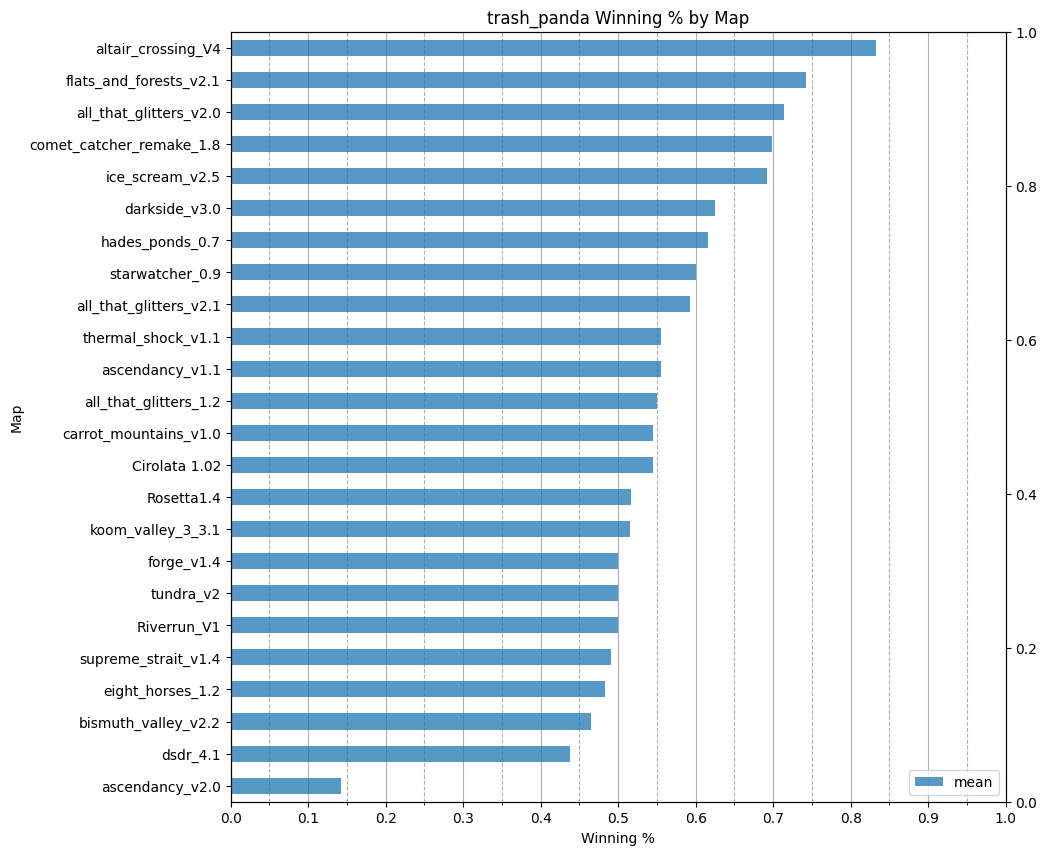

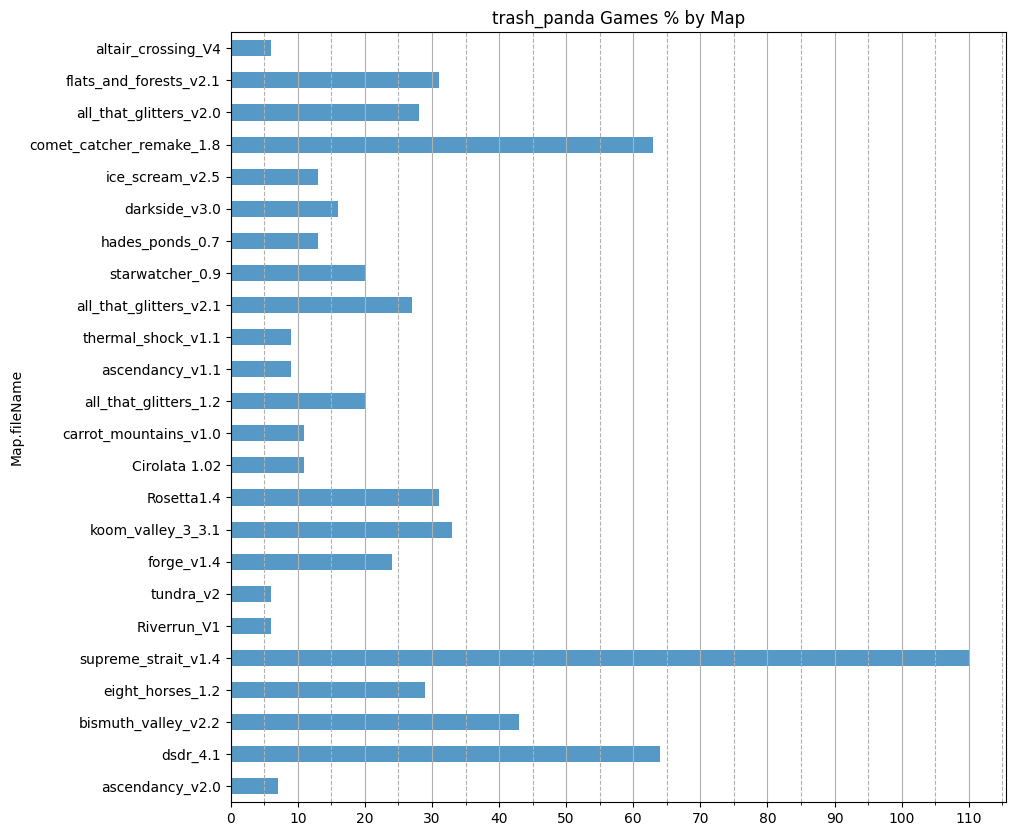

In [74]:
# Get the winning % for each map sorted by winning % and number of games played
# Set larger figure size

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams["figure.figsize"] = (10, 10)

win_rate = (
    df.groupby(["Map.fileName"])
    .agg({"winningTeam": ["mean", "count"]})["winningTeam"]
    .query("count > 5")
    .sort_values([("mean"), ("count")], ascending=True)
)

# Use win_rate and plot the winning % for each map with the number of games played with horizontal bars and subdivide the bars by the winning team
# with minor locator for the x axis. Color by count and winningTeam.

# Set the x axis minor locator to 5 and major locator to 10

fig = plt.figure(figsize=(8, 6))

ax = win_rate.plot.barh(
    y=("mean"),
    secondary_y=("count"),
    alpha=0.75,
    legend=False,
    title=f"{user} Winning % by Map",
)

ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.grid(which="minor", axis="x", linestyle="--")
ax.grid(which="major", axis="x", linestyle="-")
ax.set_xlabel("Winning %")
ax.set_ylabel("Map")
ax.set_xlim(0, 1)

ax.set_yticklabels(win_rate.index)
ax.set_axisbelow(True)
ax.legend(loc="lower right")

ax2 = ax.twinx()
ax2 = win_rate.plot.barh(
    y=("count"),
    secondary_y=("mean"),
    alpha=0.75,
    legend=False,
    title=f"{user} Games % by Map",
)
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.grid(which="minor", axis="x", linestyle="--")
ax2.grid(which="major", axis="x", linestyle="-")

plt.show()

In [ ]:
win_rate

winningTeam      
                                 mean count
Map.fileName                               
NuclearWinterR               0.000000     1
all_that_glitters_v2.1       0.000000     1
darkside_v3.0                0.000000     1
great_divide_v1              0.000000     1
hotlips_remake_v3.1          0.000000     1
ice_scream_v2.5              0.000000     1
thermal_shock_v1.1           0.000000     2
Rosetta1.4                   0.250000     4
white_fire_remake_1.2        0.333333     6
angel_crossing_1.5           0.500000     2
flats_and_forests_v2.1       0.500000     2
starwatcher_1.0              0.500000     2
sulphur_springs_v1.1         0.500000     2
ascendancy_v2.0              0.500000     4
bismuth_valley_v2.2          0.500000     6
koom_valley_3_3.1            0.600000     5
dsdr_4.1                     0.666667     9
Entrenched_Plains_V2         1.000000     1
Twin Lakes Park Redux 1.2    1.000000     1
carrot_mountains_v1.0        1.000000     1
faster_than_light_1.1        1.000000     1
forge_v1.4                   1.000000     1
supreme_strait_v1.4          1.000000     1
to_kill_the_middle_v1.0      1.000000     1
white_fire_remake_1.3        1.000000     1
eight_horses_1.2             1.000000     2

In [ ]:
# Get the overall win rate

df["winningTeam"].mean() * 100

51.66666666666667

In [ ]:
# Get the winning % for each map sorted by winning % and number of games played

df.groupby(['Map.fileName','winningTeam']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)

# df.groupby(["Map.fileName"]).agg({"winningTeam": ["count", "mean"]}).sort_values(
#     [("winningTeam", "mean")], ascending=False
# )

winningTeam,False,True
Map.fileName,,
Entrenched_Plains_V2,0.000000,1.000000
NuclearWinterR,1.000000,0.000000
Rosetta1.4,0.750000,0.250000
Twin Lakes Park Redux 1.2,0.000000,1.000000
all_that_glitters_v2.1,1.000000,0.000000
angel_crossing_1.5,0.500000,0.500000
ascendancy_v2.0,0.500000,0.500000
bismuth_valley_v2.2,0.500000,0.500000
carrot_mountains_v1.0,0.000000,1.000000
